<a href="https://colab.research.google.com/github/Mchoon84/AIFFEL_guest_cr/blob/main/Exploration/Ex04/Exploration_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트 : CIFAR-10 이미지 생성하기

In [ ]:
# 주요 라이브러리 버전 확인

import tensorflow
import imageio

print(tensorflow.__version__)
print(imageio.__version__)

2.18.0
2.37.0


##STEP 1. 작업환경 구성하기

In [ ]:
# 드라이브 마운팅

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# 디렉토리 생성
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/generated_samples', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_checkpoints', exist_ok=True)
os.makedirs('/content/aiffel/dcgan_newimage/cifar10/training_history', exist_ok=True)


##STEP 2. 데이터셋 구성하기

In [ ]:
# TensorFlow 라이브러리 임포트
import tensorflow as tf

# CIFAR-10 데이터셋을 로드
cifar10 = tf.keras.datasets.cifar10

# 훈련 데이터(train_x)와 테스트 데이터(test_x)를 로드하고, 이미지와 라벨을 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# 훈련 데이터의 shape을 출력하여 데이터 크기 확인
train_x.shape


(50000, 32, 32, 3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 데이터 로드 및 필터링 (선택적 레이블 필터링)
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label is not None:
        # 특정 레이블만 필터링
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        train_x = np.array([i for i in list(df['image'])])

        df = pd.DataFrame(list(zip(test_x, test_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# CIFAR-10 데이터 로드 (여기서는 특정 레이블을 필터링하지 않음)
train_x, test_x = load_data()

# 이미지를 -1, 1 범위로 정규화
train_x = (train_x / 127.5) - 1.0  # 0-255 범위를 -1, 1로 변환
test_x = (test_x / 127.5) - 1.0

# 데이터 시각화 (임의의 10개 이미지 출력)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])  # 정규화된 이미지를 출력
    plt.axis('off')
plt.show()

# tf.data.Dataset을 사용하여 미니배치 데이터셋 생성
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_x).batch(BATCH_SIZE)

# 학습 데이터셋 크기 확인
print(f"Training dataset batch size: {len(train_dataset)}")

Training dataset batch size: 1563


##STEP 3. 생성자 모델 구현하기

✅ (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수 생성

✅ noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성

✅ 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인

In [ ]:
from tensorflow.keras import layers, Model, Input

# 노이즈 차원 정의 (여기서 정의해서 모든 함수에서 사용할 수 있게 함)
noise_dim = 100

def make_generator_model():
    # 첫 번째 레이어는 Input으로 정의
    model_input = Input(shape=(noise_dim,))
    x = layers.Dense(8 * 8 * 256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Reshape 레이어
    x = layers.Reshape((8, 8, 256))(x)

    # Conv2DTranspose 레이어
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    x = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

    # 모델 반환
    model = Model(model_input, x)
    return model

# 생성자 모델 만들기
generator = make_generator_model()

# 랜덤 노이즈 입력
noise = tf.random.normal([1, noise_dim])

# 생성된 이미지 출력
generated_image = generator(noise, training=False)

# 생성된 이미지의 shape 출력
print("Generated image shape: ", generated_image.shape)

Generated image shape:  (1, 32, 32, 3)


##STEP 4. 판별자 모델 구현하기

✅ (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수 작성

✅ 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 첫 번째 Conv2D 레이어
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 두 번째 Conv2D 레이어
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten 레이어
    model.add(layers.Flatten())

    # 마지막 Dense 레이어 (sigmoid 활성화 제거 - from_logits=True와 일치시키기 위함)
    model.add(layers.Dense(1))

    return model

In [ ]:
# 판별자 모델 생성
discriminator = make_discriminator_model()

# 랜덤 이미지 (이전에 생성된 이미지 사용)
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# 생성된 이미지를 판별자 모델에 입력
discriminator_output = discriminator(generated_image, training=False)

# 판별자 출력 확인
print("Discriminator output: ", discriminator_output)

Discriminator output:  tf.Tensor([[-0.00487623]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


✅ 이 출력에서 0.00072631와 같은 값은 판별자가 생성된 이미지를 "진짜" 또는 "가짜"로 분류한 결과임

✅ 값이 0에 가까우면 가짜 이미지일 가능성이 높고, 1에 가까우면 진짜 이미지일 가능성이 높음

##STEP 5. 손실함수와 최적화 함수 구현하기

✅ 생성자와 판별자의 손실함수(loss) 구현

✅ 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수 구현

✅ 생성자와 판별자를 최적화하는 optimizer를 정의

In [ ]:
# 판별자 손실 함수
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 생성자 손실 함수
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)

In [ ]:
# 정확도 계산 함수 (from_logits=True에 맞게 수정)
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output > 0, tf.float32))  # logit > 0 이면 실제로 예측
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0, tf.float32))  # logit < 0 이면 가짜로 예측
    return real_accuracy, fake_accuracy

In [ ]:
# 최적화 함수 정의
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

##STEP 6. 훈련과정 상세 기능 구현하기

✅ 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수 구현

✅ 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수 구현

✅ 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수 구현

✅ training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정

In [ ]:
import time
import os
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

# 모델 저장 경로 설정
base_dir = '/content/aiffel/dcgan_newimage/cifar10'
checkpoint_dir = os.path.join(base_dir, 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Checkpoint 설정
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator, generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer)

# 시드 노이즈 정의 (이미지 생성용)
seed = tf.random.normal([1, noise_dim])

# 학습 진행 중 이미지 생성 및 저장
def generate_and_save_images(model, epoch, iteration, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions * 127.5) + 127.5  # 역정규화
    predictions = predictions.numpy().astype(np.uint8)

    # 저장 경로 설정
    img_path = os.path.join(base_dir, 'generated_samples', f'epoch_{epoch}_iter_{iteration}.png')
    plt.figure(figsize=(4, 4))
    plt.imshow(predictions[0])
    plt.axis('off')
    plt.savefig(img_path)
    plt.close()

# 학습 히스토리 그리기
def draw_train_history(history, epoch):
    plt.figure(figsize=(10, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.title('Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label='Real Accuracy')
    plt.plot(history['fake_accuracy'], label='Fake Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    # 파일로 저장
    history_img_path = os.path.join(base_dir, 'training_history', f'history_epoch_{epoch}.png')
    plt.tight_layout()
    plt.savefig(history_img_path)
    plt.close()

# 학습 함수 (값을 반환하도록 수정)
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # 명시적으로 값을 반환
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

# 모델 초기화
# 더미 데이터로 모델 호출하여 변수 초기화
dummy_noise = tf.random.normal([BATCH_SIZE, noise_dim])
dummy_images = next(iter(train_dataset))
# @tf.function 없이 변수 생성
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    dummy_generated_images = generator(dummy_noise, training=False)
    dummy_real_output = discriminator(dummy_images, training=False)
    dummy_fake_output = discriminator(dummy_generated_images, training=False)


In [ ]:
# 훈련
def train(train_dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}
    # 에포크별 통계 저장용 리스트 추가
    epoch_stats = []

    for epoch in range(epochs):
        epoch_start = time.time()
        # 에포크별 측정값 저장할 리스트
        epoch_gen_losses = []
        epoch_disc_losses = []
        epoch_real_accs = []
        epoch_fake_accs = []

        for it, image_batch in enumerate(train_dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 에포크별 통계용 데이터 추가
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)
            epoch_real_accs.append(real_accuracy)
            epoch_fake_accs.append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f'Epoch {epoch + 1} | Iter {it + 1}')
                print(f'Time for epoch {epoch + 1}: {int(time.time() - epoch_start)} sec')

        # 에포크 종료 시 평균 통계 계산
        avg_gen_loss = tf.reduce_mean(epoch_gen_losses).numpy()
        avg_disc_loss = tf.reduce_mean(epoch_disc_losses).numpy()
        avg_real_acc = tf.reduce_mean(epoch_real_accs).numpy()
        avg_fake_acc = tf.reduce_mean(epoch_fake_accs).numpy()
        avg_total_acc = (avg_real_acc + avg_fake_acc) / 2

        # 에포크 통계 저장
        epoch_stats.append({
            'epoch': epoch + 1,
            'gen_loss': avg_gen_loss,
            'disc_loss': avg_disc_loss,
            'real_acc': avg_real_acc,
            'fake_acc': avg_fake_acc,
            'total_acc': avg_total_acc
        })

        # 에포크 요약 출력
        print('\n' + '=' * 50)
        print(f'Epoch {epoch + 1}/{epochs} Summary:')
        print(f'Generator Loss: {avg_gen_loss:.4f}')
        print(f'Discriminator Loss: {avg_disc_loss:.4f}')
        print(f'Real Accuracy: {avg_real_acc:.4f}')
        print(f'Fake Accuracy: {avg_fake_acc:.4f}')
        print(f'Total Accuracy: {avg_total_acc:.4f}')
        print('=' * 50 + '\n')

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f'Time for training: {int(time.time() - start)} sec')

        draw_train_history(history, epoch)

    # 학습 완료 후 에포크별 통계 출력
    print('\n' + '#' * 50)
    print('훈련 완료! 에포크별 정확도 요약:')
    print('#' * 50)

    import pandas as pd
    stats_df = pd.DataFrame(epoch_stats)
    print(stats_df)

    # CSV 파일로 저장
    stats_path = os.path.join(base_dir, 'training_history', 'epoch_stats.csv')
    stats_df.to_csv(stats_path, index=False)
    print(f'에포크 통계가 저장되었습니다: {stats_path}')

    # 에포크별 정확도 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(stats_df['epoch'], stats_df['real_acc'], 'g-', label='Real Image Accuracy')
    plt.plot(stats_df['epoch'], stats_df['fake_acc'], 'r-', label='Fake Image Accuracy')
    plt.plot(stats_df['epoch'], stats_df['total_acc'], 'b-', label='Total Accuracy')
    plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (0.5)')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Discriminator Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    acc_plot_path = os.path.join(base_dir, 'training_history', 'accuracy_per_epoch.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f'정확도 그래프가 저장되었습니다: {acc_plot_path}')

##STEP 7. 학습 과정 진행하기

✅ 위 STEP 6에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행

✅ 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현

✅ 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출

In [ ]:
save_every = 5
EPOCHS = 50

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every=5)

Time for training: 977 sec

##################################################
훈련 완료! 에포크별 정확도 요약:
##################################################
    epoch  gen_loss  disc_loss  real_acc  fake_acc  total_acc
0       1  1.881721   0.688071  0.840691  0.885757   0.863224
1       2  1.705548   0.759033  0.811460  0.883777   0.847619
2       3  1.303276   1.021635  0.730786  0.786888   0.758837
3       4  1.055055   1.136499  0.685381  0.738804   0.712092
4       5  1.097015   1.134186  0.676104  0.736304   0.706204
5       6  1.201477   1.057331  0.713592  0.769194   0.741393
6       7  1.188004   1.101290  0.688660  0.752059   0.720359
7       8  1.200690   1.085631  0.693138  0.757997   0.725568
8       9  1.250119   1.086805  0.698836  0.754978   0.726907
9      10  1.203257   1.080429  0.695657  0.761036   0.728347
10     11  1.219177   1.103558  0.685521  0.750020   0.717770
11     12  1.151811   1.140708  0.674404  0.730006   0.702205
12     13  1.096388   1.155521  0.665667  0.

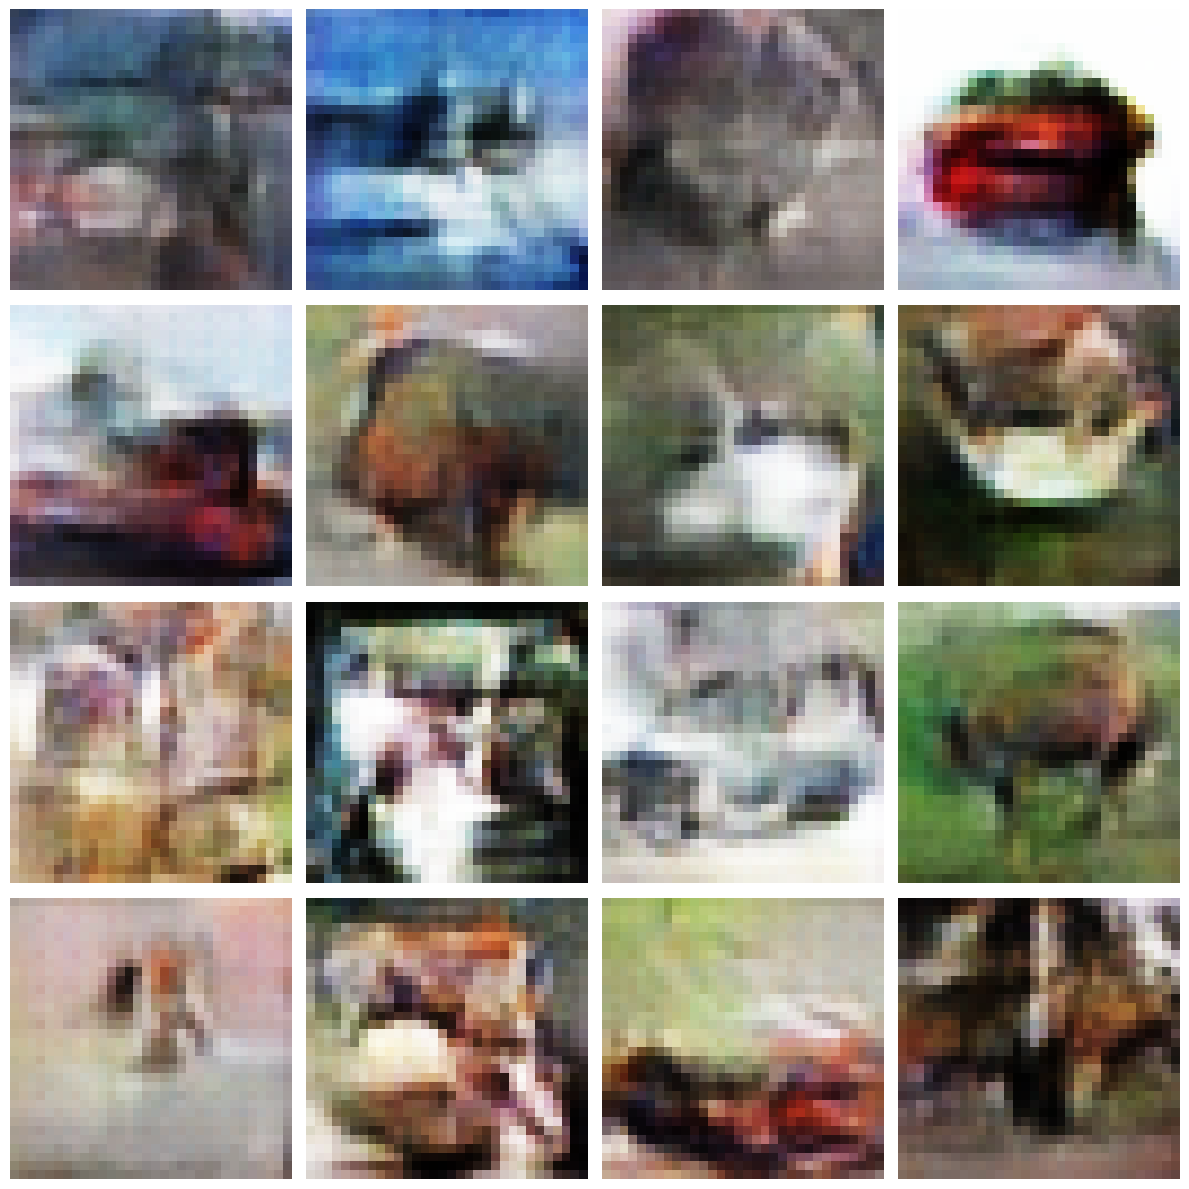

Total 51 history files generated
Latest history file: /content/aiffel/dcgan_newimage/cifar10/training_history/accuracy_per_epoch.png


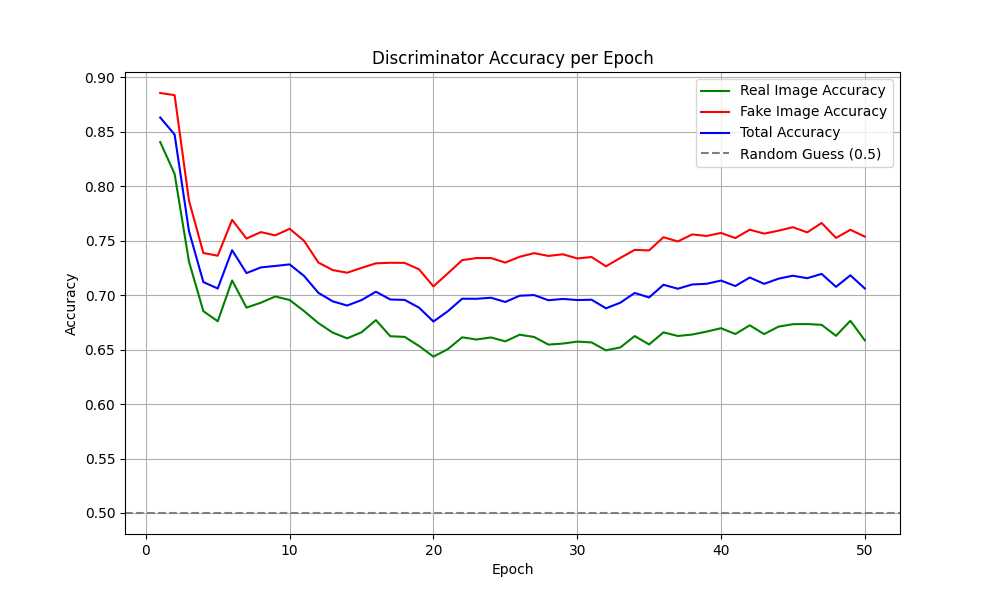

Total 1601 sample images generated


<Figure size 640x480 with 0 Axes>

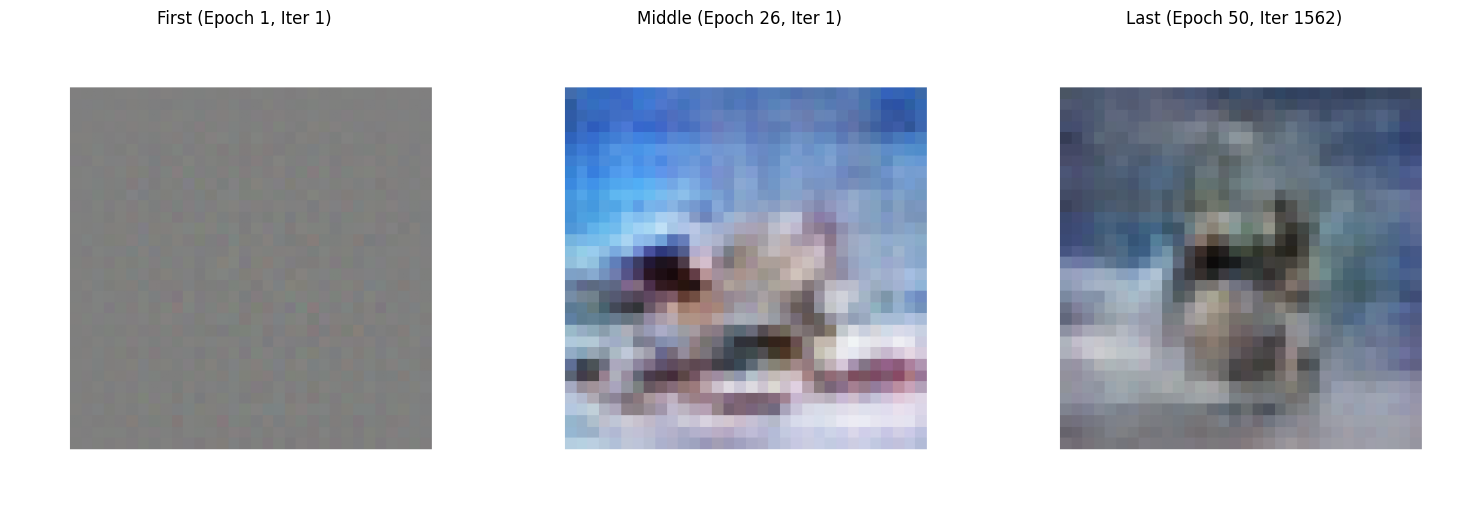

Images progression by epoch:


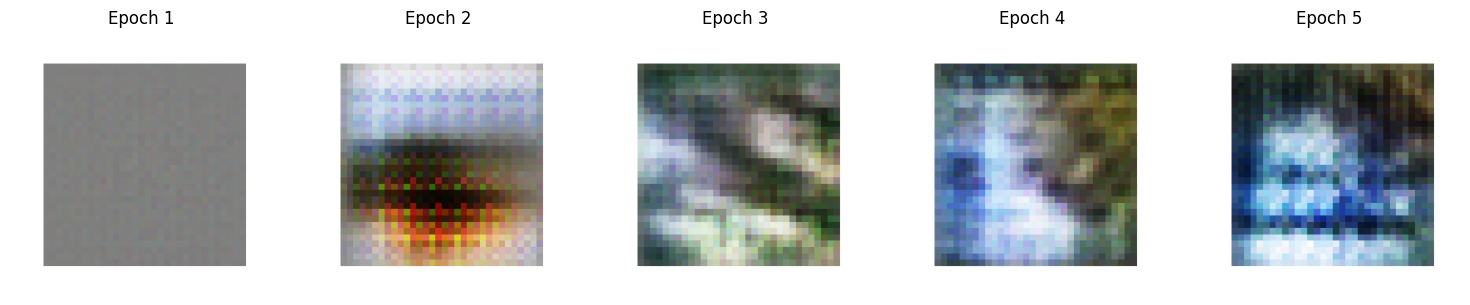

In [ ]:
# 저장된 체크포인트 로드
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 여러 이미지 생성 및 시각화
def visualize_multiple_generated_images(num_images=16):
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        # 랜덤 노이즈로 이미지 생성
        random_noise = tf.random.normal([1, noise_dim])
        predictions = generator(random_noise, training=False)

        # -1~1 범위에서 0~255 범위로 변환
        predictions = (predictions * 127.5) + 127.5
        predictions = predictions.numpy().astype(np.uint8)

        # 서브플롯에 이미지 표시
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 저장
    plt.savefig(os.path.join(base_dir, 'generated_samples', 'final_generated_grid.png'))

# 16개의 이미지 생성 및 시각화
visualize_multiple_generated_images(16)

# 학습 히스토리 파일들 확인
import glob
history_files = glob.glob(os.path.join(base_dir, 'training_history', '*.png'))
print(f"Total {len(history_files)} history files generated")

# 마지막 히스토리 파일 표시
if history_files:
    from IPython.display import Image, display
    latest_history = max(history_files, key=os.path.getctime)
    print(f"Latest history file: {latest_history}")
    display(Image(latest_history))

# 생성된 샘플 이미지 파일들 확인
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"Total {len(sample_files)} sample images generated")

# 학습 과정의 진화 시각화 (첫 번째, 중간, 마지막 에포크의 이미지)
if sample_files:
    # 파일명에서 에포크 번호 추출
    import re
    def get_epoch_iter(filename):
        match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
        if match:
            return int(match.group(1)), int(match.group(2))
        return 0, 0

    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 첫 번째, 중간, 마지막 이미지 표시
    plt.figure(figsize=(15, 5))

    # 첫 번째 이미지
    plt.subplot(1, 3, 1)
    first_img = plt.imread(sample_files[0])
    plt.imshow(first_img)
    epoch, iter_num = get_epoch_iter(sample_files[0])
    plt.title(f"First (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    # 중간 이미지
    middle_idx = len(sample_files) // 2
    plt.subplot(1, 3, 2)
    middle_img = plt.imread(sample_files[middle_idx])
    plt.imshow(middle_img)
    epoch, iter_num = get_epoch_iter(sample_files[middle_idx])
    plt.title(f"Middle (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    # 마지막 이미지
    plt.subplot(1, 3, 3)
    last_img = plt.imread(sample_files[-1])
    plt.imshow(last_img)
    epoch, iter_num = get_epoch_iter(sample_files[-1])
    plt.title(f"Last (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 학습 진행 애니메이션 생성
    print("Images progression by epoch:")

    # 에포크당 하나의 이미지만 선택 (중복 제거)
    unique_epochs = {}
    for file in sample_files:
        epoch, _ = get_epoch_iter(file)
        if epoch not in unique_epochs:
            unique_epochs[epoch] = file

    # 에포크 순서대로 정렬된 파일 목록
    sorted_epoch_files = [unique_epochs[epoch] for epoch in sorted(unique_epochs.keys())]

    # 최대 5개의 에포크 이미지만 표시 (너무 많으면 복잡해짐)
    display_files = sorted_epoch_files[:min(5, len(sorted_epoch_files))]

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(display_files):
        plt.subplot(1, len(display_files), i+1)
        img = plt.imread(file)
        plt.imshow(img)
        epoch, iter_num = get_epoch_iter(file)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

총 1601개의 샘플 이미지 발견
GIF 애니메이션이 저장되었습니다: /content/aiffel/dcgan_newimage/cifar10/generated_samples/training_progress.gif


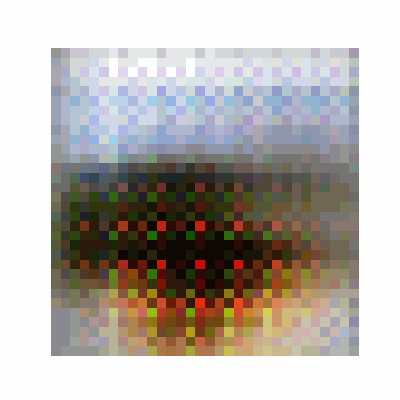

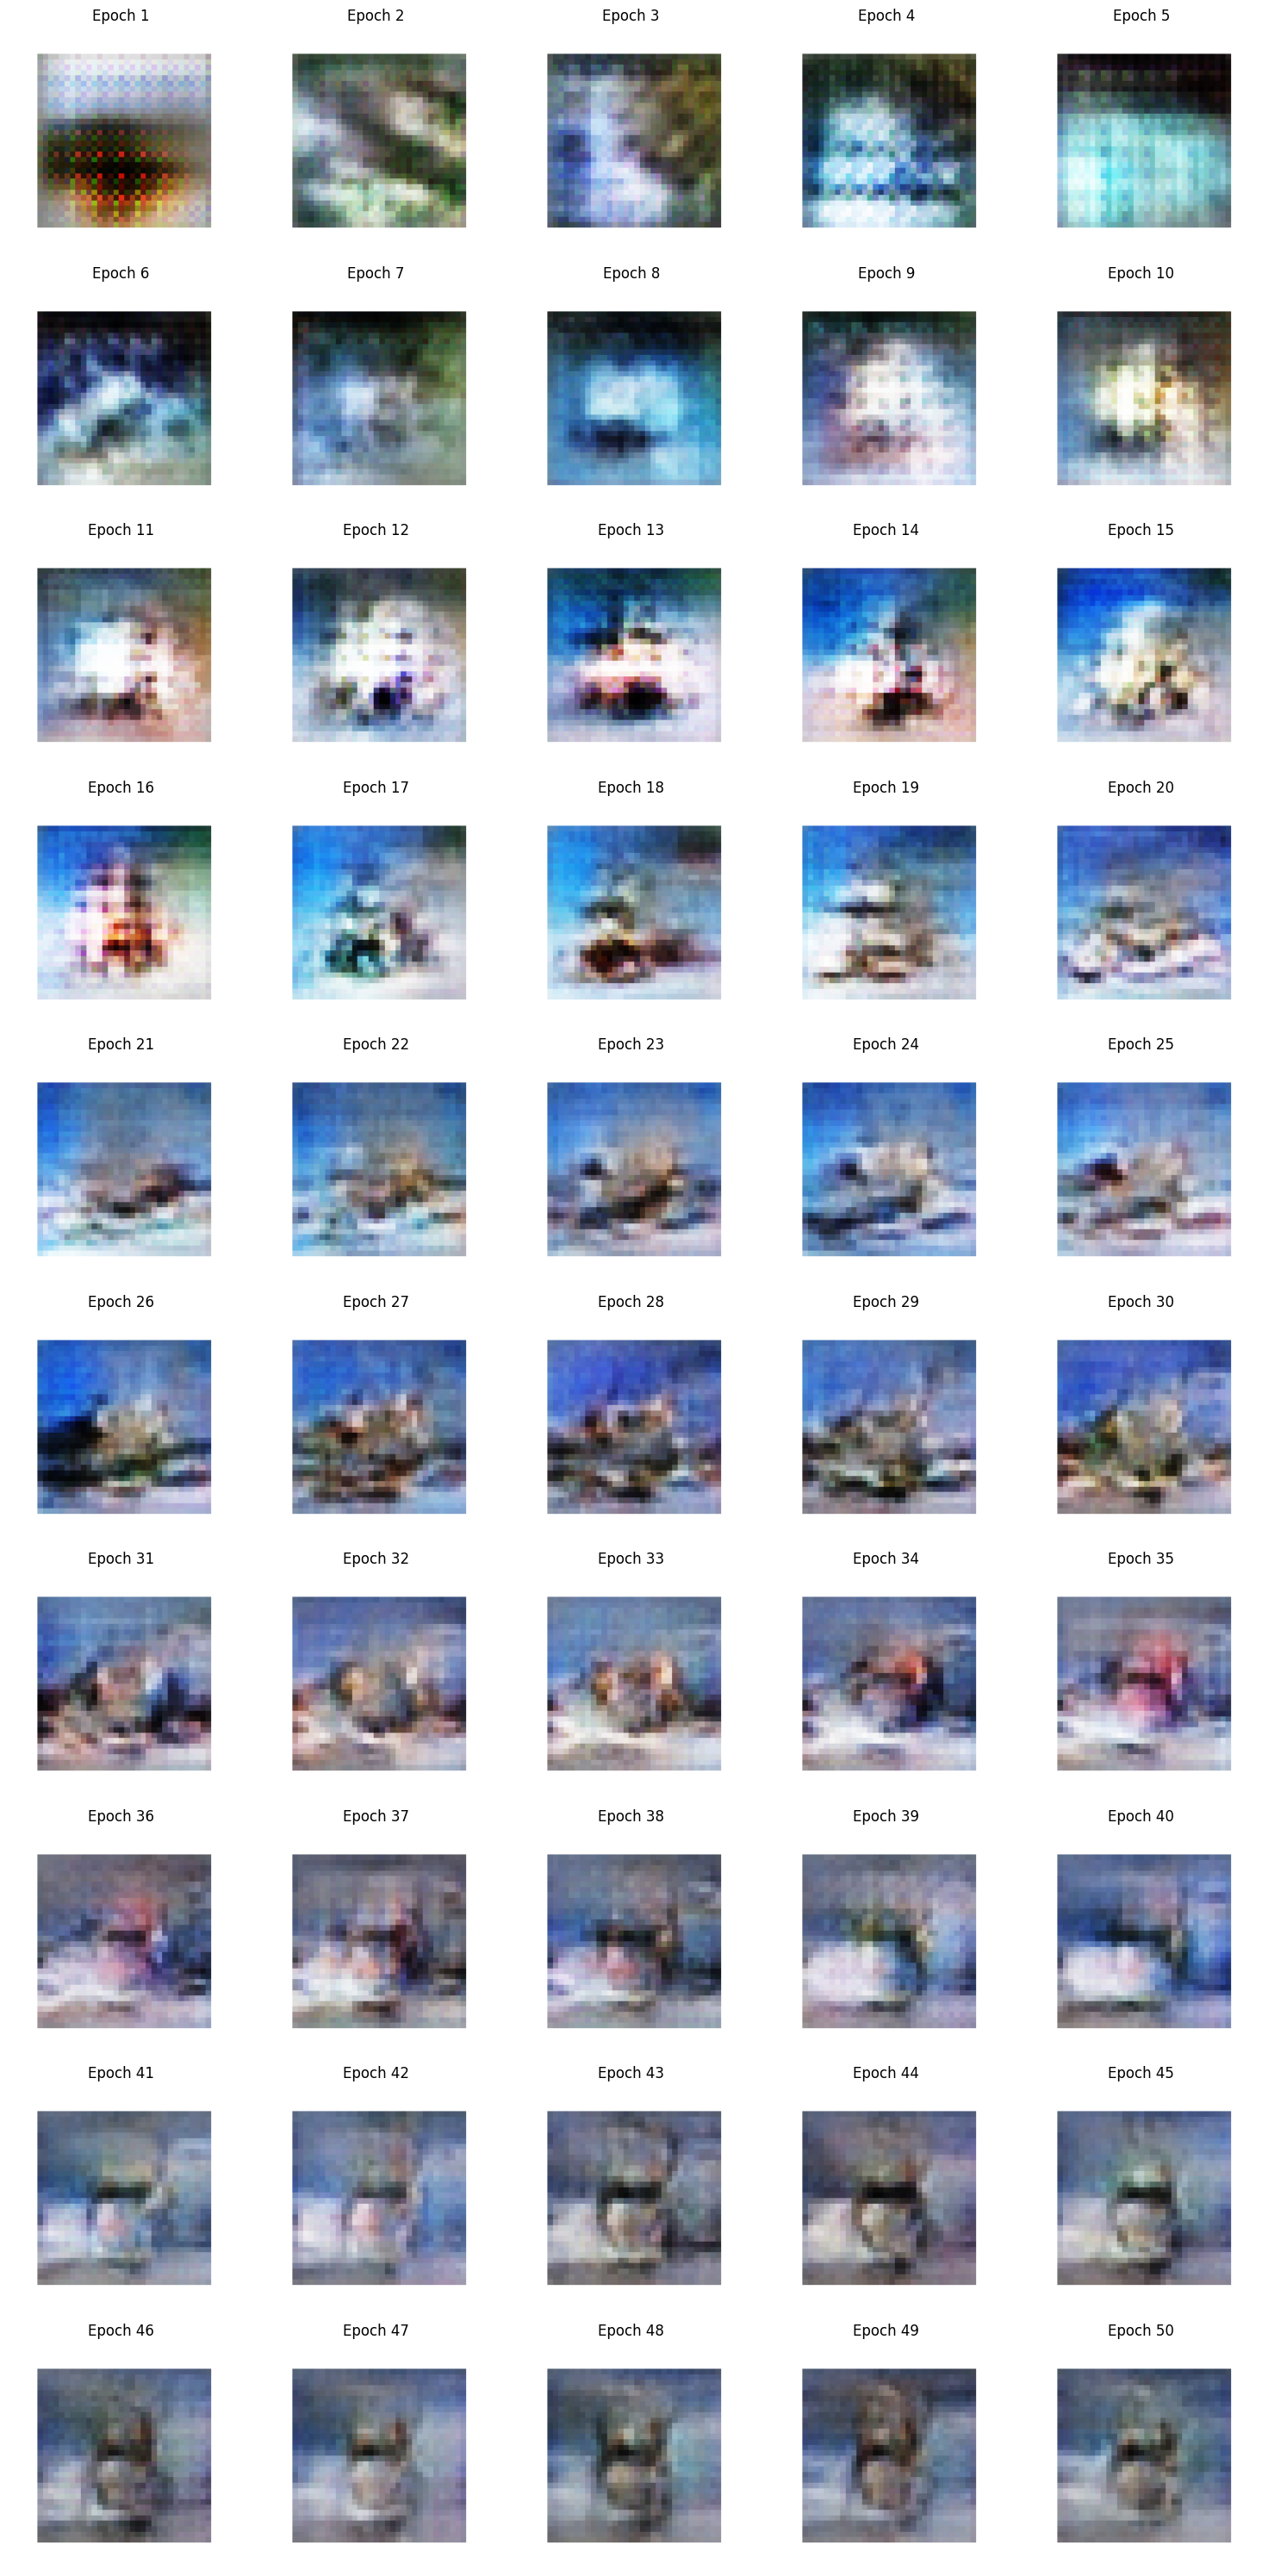

In [ ]:
# 에포크별 이미지 진화를 GIF로 만들기
import imageio.v2 as imageio
import glob
import re
import os

# 에포크 번호 추출 함수
def get_epoch_iter(filename):
    match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return 0, 0

# 샘플 이미지 파일 찾기
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"총 {len(sample_files)}개의 샘플 이미지 발견")

if sample_files:
    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 에포크별 대표 이미지 선택 (각 에포크의 마지막 반복)
    epoch_images = {}
    for file in sample_files:
        epoch, iter_num = get_epoch_iter(file)
        if epoch not in epoch_images or get_epoch_iter(epoch_images[epoch])[1] < iter_num:
            epoch_images[epoch] = file

    sorted_epochs = sorted(epoch_images.keys())
    selected_files = [epoch_images[epoch] for epoch in sorted_epochs]

    # GIF 파일 경로
    gif_path = os.path.join(base_dir, 'generated_samples', 'training_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in selected_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.5초 유지)
    imageio.mimsave(gif_path, images, duration=0.5)
    print(f"GIF 애니메이션이 저장되었습니다: {gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(gif_path))

    # 추가: 모든 에포크 이미지를 하나의 그리드로 표시
    num_epochs = len(sorted_epochs)
    rows = int(np.ceil(num_epochs / 5))  # 행당 최대 5개 이미지
    cols = min(5, num_epochs)

    plt.figure(figsize=(15, 3 * rows))
    for i, epoch in enumerate(sorted_epochs):
        plt.subplot(rows, cols, i+1)
        img = plt.imread(epoch_images[epoch])
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("생성된 이미지 파일을 찾을 수 없습니다.")

총 50개의 히스토리 파일 발견
손실 그래프 GIF 애니메이션이 저장되었습니다: /content/aiffel/dcgan_newimage/cifar10/training_history/loss_progress.gif


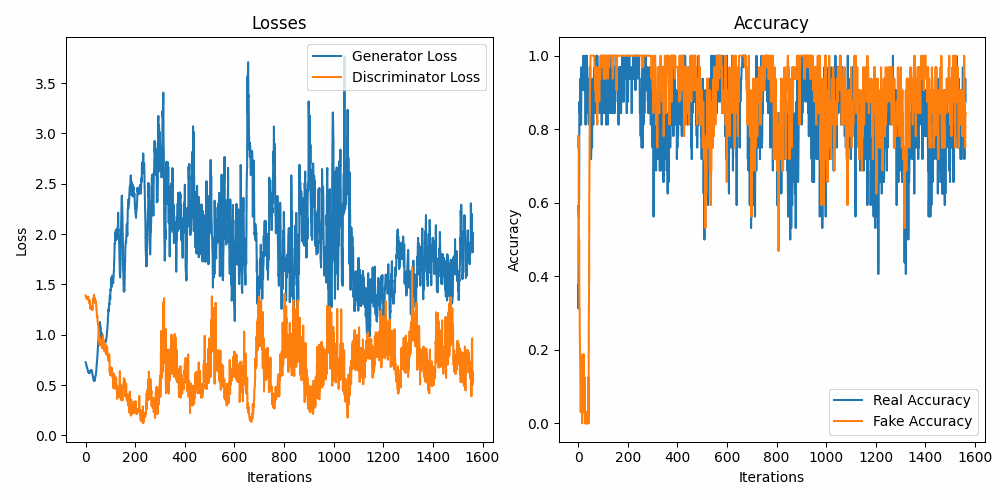

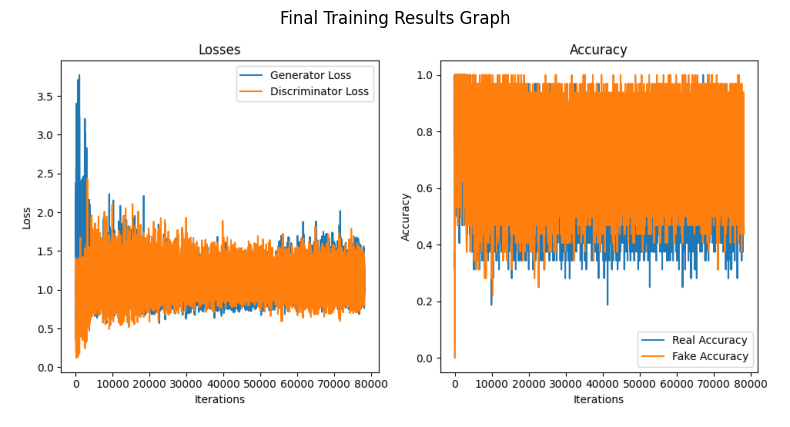

In [ ]:
# 손실(Generator Loss와 Discriminator Loss) 그래프의 에포크별 애니메이션 생성
import imageio.v2 as imageio
import glob
import re
import os
import matplotlib.pyplot as plt
import numpy as np

# 히스토리 이미지 파일 찾기
history_files = glob.glob(os.path.join(base_dir, 'training_history', 'history_epoch_*.png'))
print(f"총 {len(history_files)}개의 히스토리 파일 발견")

if history_files:
    # 에포크 번호 추출 함수
    def get_epoch(filename):
        match = re.search(r'history_epoch_(\d+).png', filename)
        if match:
            return int(match.group(1))
        return 0

    # 에포크별로 정렬
    history_files.sort(key=get_epoch)

    # GIF 파일 경로
    loss_gif_path = os.path.join(base_dir, 'training_history', 'loss_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in history_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.7초 유지)
    imageio.mimsave(loss_gif_path, images, duration=0.7)
    print(f"손실 그래프 GIF 애니메이션이 저장되었습니다: {loss_gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(loss_gif_path))
else:
    print("히스토리 그래프 파일을 찾을 수 없습니다.")

# 추가: 마지막 히스토리 그래프 표시
if history_files:
    latest_history = max(history_files, key=os.path.getctime)
    plt.figure(figsize=(10, 5))
    img = plt.imread(latest_history)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Final Training Results Graph")
    plt.show()

✅ 현재 그래프만 보면 GAN은 아직 학습 초반 또는 생성자가 판별자에게 밀리고 있는 중

✅ Fake Accuracy가 0.5에 가까워지면 → 생성자의 성능이 좋아지고 있다는 뜻

✅ 아직은 0.5 수렴 추세가 뚜렷하진 않음

##STEP 8. (optional) GAN 훈련 과정 개선하기

✅ STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점 분석

✅ 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 제출

### 1.훈련 결과 요약

```
항목                   | 설명
-----------------------|------------------------------------------------------------------------------------------------------------
훈련 기간              | 총 50 에포크
Generator Loss         | 초반 1.88 수준에서 → 중반 이후 1.07~1.19 사이로 점진적인 변화
Discriminator Loss     | 초반 0.69 수준에서 → 이후 1.08~1.19 사이로 유지
Discriminator Accuracy | fake_acc > real_acc 현상 지속 (epoch 20~50)
Total Accuracy         | 0.68~0.75 범위에서 정체, epoch 20 이후 큰 변화 없음
```


### 2. 이전 훈련 과정의 문제점 요약

```
문제                    | 설명
------------------------|------------------------------------------------------------------------------------------------------------
Plateau 현상            | epoch 20 이후 손실 및 정확도 모두 큰 변화 없음
구분 정확도 불균형      | fake_acc consistently > real_acc → generator가 현실보다 더 판별 쉬운 이미지 생성 가능성
Generator loss 미감소   | 1.0 이하로 떨어지지 않음 → 생성 이미지 품질 개선 부족 가능성
총 정확도 개선 없음     | 총 정확도가 0.68~0.75 범위에서 정체됨 → discriminator 학습 효과 제한적
```

### 3. 모델 구조 또는 학습 과정 개선 방안

```
개선 조치                   | 설명
----------------------------|--------------------------------------------------------------
학습률 조정                 | Discriminator의 learning rate를 낮춤 → 1e-4 → 1e-5로 변경 →너무 빨리 학습하는 것을 막아 Generator가 조금 더 따라올 수 있도록 유도
Label Smoothing 적용        | Discriminator에 Label Smoothing 적용 → Real label을 1.0이 아닌 0.9로 설정 → 너무 확신을 가지지 않도록 하여 Generator 학습 안정화
Optimizer 변경              | Adam의 beta 값을 (0.5, 0.999)로 조정 → DCGAN 논문에 따라 안정적인 학습 유도
Generator 업샘플링 개선     | Conv2DTranspose 레이어 구조를 조금 더 깊게 조정하여 고해상도 생성 유도
```

### 3. 모델 구조 또는 학습 과정 개선 방안

```
개선 조치                                    | 설명
---------------------------------------------|----------------------------------------------------------------------
  Wasserstein GAN with Gradient Penalty      | 기존 BCE 손실 함수 대신 Wasserstein 손실 사용 → Gradient Penalty 추가로 립시츠 제약 강화 → 판별자의 sigmoid 활성화 함수 제거
  아키텍처 개선                              | 판별자에 Spectral Normalization 적용 → 학습 안정성 향상
                                             | 생성자에 Residual Block(스킵 커넥션) 추가 → 더 깊고 복잡한 모델로 개선
                                             | 판별자와 생성자 모두 더 깊은 네트워크로 구성 → 더 복잡한 데이터 분포를 학습하기 위한 구조
  학습 전략 개선                             | 생성자와 판별자에 다른 학습률 적용 → 판별자는 더 낮게 설정 (학습 균형을 맞추기 위해)
                                             | n_critic=5로 설정하여 판별자를 더 자주 업데이트 → WGAN 권장사항에 따른 안정적인 학습
                                             | 학습률 스케줄링 적용 → 에포크가 진행됨에 따라 학습률 감소 (학습 안정화 유도)
                                             | 배치 크기를 32에서 64로 증가 → 더 안정적인 그래디언트 계산
```




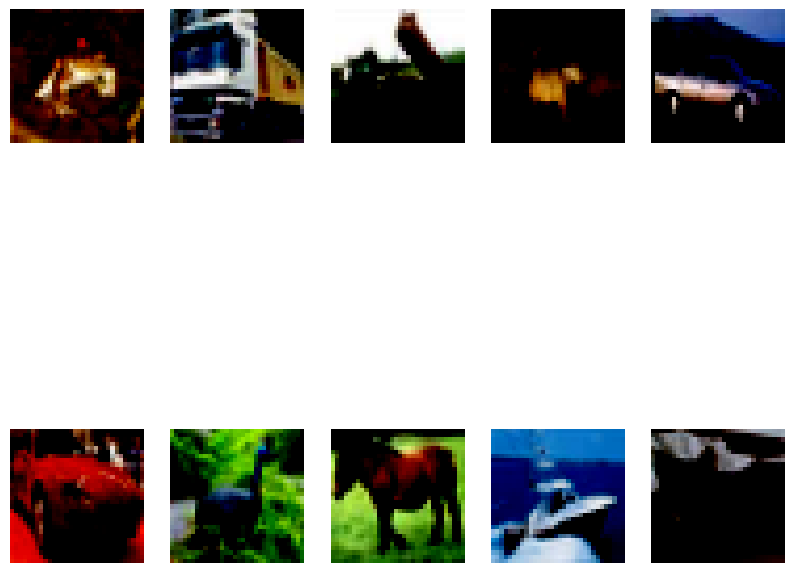

In [ ]:
# TensorFlow 라이브러리 임포트
import tensorflow as tf

# CIFAR-10 데이터셋을 로드
cifar10 = tf.keras.datasets.cifar10

# 훈련 데이터(train_x)와 테스트 데이터(test_x)를 로드하고, 이미지와 라벨을 분리
(train_x, _), (test_x, _) = cifar10.load_data()

# 훈련 데이터의 shape을 출력하여 데이터 크기 확인
train_x.shape
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython import display
import glob
import re
import imageio.v2 as imageio

# 데이터 로드 및 필터링 (선택적 레이블 필터링)
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label is not None:
        # 특정 레이블만 필터링
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        train_x = np.array([i for i in list(df['image'])])

        df = pd.DataFrame(list(zip(test_x, test_y)), columns=['image', 'label'])
        df = df[df['label'] == label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

# CIFAR-10 데이터 로드 (여기서는 특정 레이블을 필터링하지 않음)
train_x, test_x = load_data()

# 이미지를 -1, 1 범위로 정규화
train_x = (train_x / 127.5) - 1.0  # 0-255 범위를 -1, 1로 변환
test_x = (test_x / 127.5) - 1.0

# 데이터 시각화 (임의의 10개 이미지 출력)
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])  # 정규화된 이미지를 출력
    plt.axis('off')
plt.show()

In [ ]:
# tf.data.Dataset을 사용하여 미니배치 데이터셋 생성
BATCH_SIZE = 64  # 배치 사이즈 증가
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(10000).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_x).batch(BATCH_SIZE)

# 학습 데이터셋 크기 확인
print(f"Training dataset batch count: {len(train_dataset)}")

# 노이즈 차원 정의
noise_dim = 100

# 기본 설정
base_dir = '/content/aiffel/dcgan_newimage/cifar10'

Training dataset batch count: 782


In [ ]:
class SpectralNormalization(tf.keras.layers.Wrapper):
    def __init__(self, layer, iteration=1, **kwargs):
        super(SpectralNormalization, self).__init__(layer, **kwargs)
        self.iteration = iteration

    def build(self, input_shape):
        self.layer.build(input_shape)
        if not hasattr(self.layer, 'kernel'):
            raise ValueError(f'Wrapped layer {self.layer.name} does not have a `kernel` attribute.')

        self.w = self.layer.kernel
        w_shape = self.w.shape.as_list()

        self.u = self.add_weight(
            shape=(1, w_shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name='sn_u'
        )

        super(SpectralNormalization, self).build()

    def compute_spectral_norm(self, w):
        w_reshaped = tf.reshape(w, [-1, w.shape[-1]])
        u = self.u

        for _ in range(self.iteration):
            v = tf.nn.l2_normalize(tf.matmul(u, tf.transpose(w_reshaped)))
            u = tf.nn.l2_normalize(tf.matmul(v, w_reshaped))

        self.u.assign(u)
        sigma = tf.matmul(tf.matmul(v, w_reshaped), tf.transpose(u))
        return w / sigma

    def call(self, inputs):
        # 커널 정규화
        w_bar = self.compute_spectral_norm(self.w)

        # 레이어 타입에 따라 호출 방식 다르게 처리
        if isinstance(self.layer, tf.keras.layers.Conv2D):
            outputs = tf.nn.conv2d(
                inputs,
                filters=w_bar,
                strides=self.layer.strides,
                padding=self.layer.padding.upper(),
                data_format='NHWC'
            )
            if self.layer.use_bias:
                outputs = tf.nn.bias_add(outputs, self.layer.bias)
            return outputs

        elif isinstance(self.layer, tf.keras.layers.Dense):
            outputs = tf.matmul(inputs, w_bar)
            if self.layer.use_bias:
                outputs = tf.nn.bias_add(outputs, self.layer.bias)
            return outputs

        else:
            raise NotImplementedError(f'SpectralNormalization not implemented for layer type {type(self.layer)}')


In [ ]:
# ResBlock for Generator (스킵 커넥션으로 생성자 성능 강화)
def residual_block(x, filters, kernel_size=3, strides=1, use_bias=False):
    input_channels = x.shape[-1]
    res = x

    # 첫 번째 컨볼루션 레이어
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same', use_bias=use_bias)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # 두 번째 컨볼루션 레이어
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=1, padding='same', use_bias=use_bias)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # 스킵 커넥션 - 입력 차원을 출력 차원에 맞게 조정
    if strides > 1 or input_channels != filters:
        res = tf.keras.layers.Conv2DTranspose(filters, 1, strides=strides, padding='same', use_bias=use_bias)(res)
        res = tf.keras.layers.BatchNormalization()(res)

    # 스킵 커넥션 추가
    x = tf.keras.layers.add([x, res])
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    return x

In [ ]:
# 개선된 Generator 모델
def make_generator_model():
    from tensorflow.keras import layers, Model, Input

    # 입력 레이어
    model_input = Input(shape=(noise_dim,))

    # 초기 Dense 레이어
    x = layers.Dense(8 * 8 * 256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Reshape
    x = layers.Reshape((8, 8, 256))(x)

    # Residual blocks with upsampling (차원 일치 확인)
    x = residual_block(x, 256, strides=1)  # 8x8x256 -> 8x8x256 (차원 변화 없음)
    x = residual_block(x, 128, strides=2)  # 8x8x256 -> 16x16x128 (업샘플링)

    # 마지막 업샘플링 및 출력
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # 출력 레이어 (CIFAR-10 = 32x32x3)
    x = layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', use_bias=False, activation='tanh')(x)

    # 모델 생성
    model = Model(model_input, x)
    return model

In [ ]:
# 개선된 Discriminator 모델 (Spectral Normalization 적용)
def make_discriminator_model():
    from tensorflow.keras import layers

    model = tf.keras.Sequential()

    # 첫 번째 Conv2D 레이어 (Spectral Normalization 적용)
    model.add(SpectralNormalization(
        layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(32, 32, 3))
    ))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 두 번째 Conv2D 레이어
    model.add(SpectralNormalization(
        layers.Conv2D(128, kernel_size=4, strides=2, padding='same')
    ))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # 세 번째 Conv2D 레이어 (추가적인 깊이)
    model.add(SpectralNormalization(
        layers.Conv2D(256, kernel_size=3, strides=1, padding='same')
    ))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    # Flatten 및 출력
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # No sigmoid (for Wasserstein loss)

    return model

In [ ]:
# 모델 초기화
generator = make_generator_model()
discriminator = make_discriminator_model()

# WGAN-GP 기반 손실 함수
def wasserstein_loss(real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

# Generator 손실 함수
def generator_loss(fake_logits):
    return -tf.reduce_mean(fake_logits)

# Gradient Penalty 구현
def gradient_penalty(model, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]

    # 무작위 가중치 생성 - dtype 명시적으로 지정
    alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0, dtype=tf.float32)

    # 이미지들을 float32로 변환
    real_images = tf.cast(real_images, dtype=tf.float32)
    fake_images = tf.cast(fake_images, dtype=tf.float32)

    # float64 방지!
    one = tf.constant(1.0, dtype=tf.float32)
    interpolated = alpha * real_images + (one - alpha) * fake_images

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = model(interpolated, training=True)

    grads = gp_tape.gradient(pred, interpolated)
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-10)
    gp = tf.reduce_mean((slopes - 1.0) ** 2)

    return gp


In [ ]:
# 정확도 계산 함수 (for monitoring only)
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output < 0, tf.float32))  # real < 0 예측시 정확
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output > 0, tf.float32))  # fake > 0 예측시 정확
    return 1.0 - real_accuracy, fake_accuracy  # WGAN에서는 방향이 반대로 됨

# 학습률 조정 - 판별자는 더 작게, 생성자는 약간 더 크게
generator_lr = 1e-4
discriminator_lr = 5e-5  # 판별자 학습률을 더 작게 설정

# 최적화 함수 (WGAN 권장 설정)
generator_optimizer = tf.keras.optimizers.Adam(generator_lr, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(discriminator_lr, beta_1=0.5, beta_2=0.9)

In [ ]:
# 체크포인트 설정
checkpoint_dir = os.path.join(base_dir, 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer
)

# 시드 노이즈 정의 (이미지 생성용)
seed = tf.random.normal([1, noise_dim])

# WGAN-GP 학습 파라미터
n_critic = 5  # 판별자를 생성자보다 더 자주 학습
lambda_gp = 10.0  # Gradient Penalty 가중치

# 개선된 학습 스텝 (WGAN-GP)
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]

    # Discriminator 학습 (판별자 n_critic번 업데이트)
    for _ in range(n_critic):
        noise = tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as disc_tape:
            # 진짜 이미지와 가짜 이미지에 대한 판별 결과
            real_output = discriminator(images, training=True)

            # 가짜 이미지 생성
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=True)

            # Wasserstein 손실 계산
            disc_loss = wasserstein_loss(real_output, fake_output)

            # Gradient Penalty 계산
            gp = gradient_penalty(discriminator, images, generated_images)
            disc_loss = disc_loss + lambda_gp * gp

        # 판별자 가중치 업데이트
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Generator 학습 (생성자는 1번만 업데이트)
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape:
        # 가짜 이미지 생성
        generated_images = generator(noise, training=True)

        # 가짜 이미지에 대한 판별 결과
        fake_output = discriminator(generated_images, training=True)

        # 생성자 손실 계산
        gen_loss = generator_loss(fake_output)

    # 생성자 가중치 업데이트
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    # 모니터링을 위한 정확도 계산 (WGAN에서는 크게 의미가 없지만 참고용)
    real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [ ]:
# 이미지 생성 및 저장 함수
def generate_and_save_images(model, epoch, iteration, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions * 127.5) + 127.5  # 역정규화
    predictions = predictions.numpy().astype(np.uint8)

    # 저장 경로 설정
    img_path = os.path.join(base_dir, 'generated_samples', f'epoch_{epoch}_iter_{iteration}.png')
    plt.figure(figsize=(4, 4))
    plt.imshow(predictions[0])
    plt.axis('off')
    plt.savefig(img_path)
    plt.close()

# 학습 히스토리 그리기
def draw_train_history(history, epoch):
    plt.figure(figsize=(10, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history['gen_loss'], label='Generator Loss')
    plt.plot(history['disc_loss'], label='Discriminator Loss')
    plt.title('Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history['real_accuracy'], label='Real Accuracy')
    plt.plot(history['fake_accuracy'], label='Fake Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()

    # 파일로 저장
    history_img_path = os.path.join(base_dir, 'training_history', f'history_epoch_{epoch}.png')
    plt.tight_layout()
    plt.savefig(history_img_path)
    plt.close()

In [ ]:
# 학습률 스케줄링 함수 (에포크에 따라 학습률 감소)
def decay_learning_rate(epoch, initial_lr):
    return initial_lr * (1.0 / (1.0 + 0.1 * epoch))

# 모델 변수 초기화 (더미 데이터로 호출)
dummy_noise = tf.random.normal([BATCH_SIZE, noise_dim])

# train_x에서 하나의 배치를 가져와서 dummy_images로 설정
dummy_images = next(iter(train_dataset))

# 더미 데이터를 사용하여 그라디언트 계산
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # 생성자에 더미 노이즈 입력
    dummy_generated_images = generator(dummy_noise, training=False)

    # 판별자에 더미 이미지 입력
    dummy_real_output = discriminator(dummy_images, training=False)
    dummy_fake_output = discriminator(dummy_generated_images, training=False)

In [ ]:
# 전체 학습 함수
def train(train_dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss': [], 'disc_loss': [], 'real_accuracy': [], 'fake_accuracy': []}
    epoch_stats = []

    # Learning rate 스케줄링을 위한 초기값 저장
    initial_gen_lr = generator_optimizer.learning_rate.numpy()
    initial_disc_lr = discriminator_optimizer.learning_rate.numpy()

    for epoch in range(epochs):
        epoch_start = time.time()
        # 에포크별 측정값 저장할 리스트
        epoch_gen_losses = []
        epoch_disc_losses = []
        epoch_real_accs = []
        epoch_fake_accs = []

        # 학습률 감소
        if epoch > 0:  # 첫 에포크는 그대로 진행
            new_gen_lr = decay_learning_rate(epoch, initial_gen_lr)
            new_disc_lr = decay_learning_rate(epoch, initial_disc_lr)
            generator_optimizer.learning_rate.assign(new_gen_lr)
            discriminator_optimizer.learning_rate.assign(new_disc_lr)
            print(f"Epoch {epoch+1}: Gen LR = {new_gen_lr:.6f}, Disc LR = {new_disc_lr:.6f}")

        for it, image_batch in enumerate(train_dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            # 에포크별 통계용 데이터 추가
            epoch_gen_losses.append(gen_loss)
            epoch_disc_losses.append(disc_loss)
            epoch_real_accs.append(real_accuracy)
            epoch_fake_accs.append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch + 1, it + 1, seed)
                print(f'Epoch {epoch + 1} | Iter {it + 1}')
                print(f'Time for iteration: {int(time.time() - epoch_start)} sec')
                print(f'Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}')
                print(f'Real Acc: {real_accuracy:.4f}, Fake Acc: {fake_accuracy:.4f}')

        # 에포크 종료 시 평균 통계 계산
        avg_gen_loss = tf.reduce_mean(epoch_gen_losses).numpy()
        avg_disc_loss = tf.reduce_mean(epoch_disc_losses).numpy()
        avg_real_acc = tf.reduce_mean(epoch_real_accs).numpy()
        avg_fake_acc = tf.reduce_mean(epoch_fake_accs).numpy()
        avg_total_acc = (avg_real_acc + avg_fake_acc) / 2

        # 에포크 통계 저장
        epoch_stats.append({
            'epoch': epoch + 1,
            'gen_loss': avg_gen_loss,
            'disc_loss': avg_disc_loss,
            'real_acc': avg_real_acc,
            'fake_acc': avg_fake_acc,
            'total_acc': avg_total_acc
        })

        # 에포크 요약 출력
        print('\n' + '=' * 50)
        print(f'Epoch {epoch + 1}/{epochs} Summary:')
        print(f'Generator Loss: {avg_gen_loss:.4f}')
        print(f'Discriminator Loss: {avg_disc_loss:.4f}')
        print(f'Real Accuracy: {avg_real_acc:.4f}')
        print(f'Fake Accuracy: {avg_fake_acc:.4f}')
        print(f'Total Accuracy: {avg_total_acc:.4f}')
        print('=' * 50 + '\n')

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f'Time for training: {int(time.time() - start)} sec')

        draw_train_history(history, epoch)

    # 학습 완료 후 에포크별 통계 출력
    print('\n' + '#' * 50)
    print('Training completed! Epoch accuracy summary:')
    print('#' * 50)

    import pandas as pd
    stats_df = pd.DataFrame(epoch_stats)
    print(stats_df)

    # CSV 파일로 저장
    stats_path = os.path.join(base_dir, 'training_history', 'epoch_stats.csv')
    stats_df.to_csv(stats_path, index=False)
    print(f'Epoch statistics saved to: {stats_path}')

    # 에포크별 정확도 그래프
    plt.figure(figsize=(10, 6))
    plt.plot(stats_df['epoch'], stats_df['real_acc'], 'g-', label='Real Image Accuracy')
    plt.plot(stats_df['epoch'], stats_df['fake_acc'], 'r-', label='Fake Image Accuracy')
    plt.plot(stats_df['epoch'], stats_df['total_acc'], 'b-', label='Total Accuracy')
    plt.axhline(y=0.5, color='gray', linestyle='--', label='Random Guess (0.5)')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Discriminator Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # 그래프 저장
    acc_plot_path = os.path.join(base_dir, 'training_history', 'accuracy_per_epoch.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f'Accuracy graph saved to: {acc_plot_path}')



In [ ]:
# 학습 실행
save_every = 5
EPOCHS = 50

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every=5)

Epoch 24 | Iter 1
Time for iteration: 0 sec
Gen Loss: -7.8366, Disc Loss: -0.3276
Real Acc: 1.0000, Fake Acc: 1.0000


In [ ]:
# 저장된 체크포인트 로드
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 여러 이미지 생성 및 시각화
def visualize_multiple_generated_images(num_images=16):
    plt.figure(figsize=(12, 12))

    for i in range(num_images):
        # 랜덤 노이즈로 이미지 생성
        random_noise = tf.random.normal([1, noise_dim])
        predictions = generator(random_noise, training=False)

        # -1~1 범위에서 0~255 범위로 변환
        predictions = (predictions * 127.5) + 127.5
        predictions = predictions.numpy().astype(np.uint8)

        # 서브플롯에 이미지 표시
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 저장
    plt.savefig(os.path.join(base_dir, 'generated_samples', 'final_generated_grid.png'))

# 16개의 이미지 생성 및 시각화
visualize_multiple_generated_images(16)

# 학습 히스토리 파일들 확인
import glob
history_files = glob.glob(os.path.join(base_dir, 'training_history', '*.png'))
print(f"Total {len(history_files)} history files generated")

# 마지막 히스토리 파일 표시
if history_files:
    from IPython.display import Image, display
    latest_history = max(history_files, key=os.path.getctime)
    print(f"Latest history file: {latest_history}")
    display(Image(latest_history))

# 생성된 샘플 이미지 파일들 확인
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"Total {len(sample_files)} sample images generated")

# 학습 과정의 진화 시각화 (첫 번째, 중간, 마지막 에포크의 이미지)
if sample_files:
    # 파일명에서 에포크 번호 추출
    import re
    def get_epoch_iter(filename):
        match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
        if match:
            return int(match.group(1)), int(match.group(2))
        return 0, 0

    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 첫 번째, 중간, 마지막 이미지 표시
    plt.figure(figsize=(15, 5))

    # 첫 번째 이미지
    plt.subplot(1, 3, 1)
    first_img = plt.imread(sample_files[0])
    plt.imshow(first_img)
    epoch, iter_num = get_epoch_iter(sample_files[0])
    plt.title(f"First (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    # 중간 이미지
    middle_idx = len(sample_files) // 2
    plt.subplot(1, 3, 2)
    middle_img = plt.imread(sample_files[middle_idx])
    plt.imshow(middle_img)
    epoch, iter_num = get_epoch_iter(sample_files[middle_idx])
    plt.title(f"Middle (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    # 마지막 이미지
    plt.subplot(1, 3, 3)
    last_img = plt.imread(sample_files[-1])
    plt.imshow(last_img)
    epoch, iter_num = get_epoch_iter(sample_files[-1])
    plt.title(f"Last (Epoch {epoch}, Iter {iter_num})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 학습 진행 애니메이션 생성
    print("Images progression by epoch:")

    # 에포크당 하나의 이미지만 선택 (중복 제거)
    unique_epochs = {}
    for file in sample_files:
        epoch, _ = get_epoch_iter(file)
        if epoch not in unique_epochs:
            unique_epochs[epoch] = file

    # 에포크 순서대로 정렬된 파일 목록
    sorted_epoch_files = [unique_epochs[epoch] for epoch in sorted(unique_epochs.keys())]

    # 최대 5개의 에포크 이미지만 표시 (너무 많으면 복잡해짐)
    display_files = sorted_epoch_files[:min(5, len(sorted_epoch_files))]

    plt.figure(figsize=(15, 3))
    for i, file in enumerate(display_files):
        plt.subplot(1, len(display_files), i+1)
        img = plt.imread(file)
        plt.imshow(img)
        epoch, iter_num = get_epoch_iter(file)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# 에포크별 이미지 진화를 GIF로 만들기
import imageio.v2 as imageio
import glob
import re
import os

# 에포크 번호 추출 함수
def get_epoch_iter(filename):
    match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return 0, 0

# 샘플 이미지 파일 찾기
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"Total {len(sample_files)} sample images found")

if sample_files:
    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 에포크별 대표 이미지 선택 (각 에포크의 마지막 반복)
    epoch_images = {}
    for file in sample_files:
        epoch, iter_num = get_epoch_iter(file)
        if epoch not in epoch_images or get_epoch_iter(epoch_images[epoch])[1] < iter_num:
            epoch_images[epoch] = file

    sorted_epochs = sorted(epoch_images.keys())
    selected_files = [epoch_images[epoch] for epoch in sorted_epochs]

    # GIF 파일 경로
    gif_path = os.path.join(base_dir, 'generated_samples', 'training_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in selected_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.5초 유지)
    imageio.mimsave(gif_path, images, duration=0.5)
    print(f"GIF animation saved to: {gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(gif_path))

    # 추가: 모든 에포크 이미지를 하나의 그리드로 표시
    num_epochs = len(sorted_epochs)
    rows = int(np.ceil(num_epochs / 5))  # 행당 최대 5개 이미지
    cols = min(5, num_epochs)

    plt.figure(figsize=(15, 3 * rows))
    for i, epoch in enumerate(sorted_epochs):
        plt.subplot(rows, cols, i+1)
        img = plt.imread(epoch_images[epoch])
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No generated image files found.")

# 손실(Generator Loss와 Discriminator Loss) 그래프의 에포크별 애니메이션 생성
import imageio.v2 as imageio
import glob
import re
import os
import matplotlib.pyplot as plt
import numpy as np

# 히스토리 이미지 파일 찾기
history_files = glob.glob(os.path.join(base_dir, 'training_history', 'history_epoch_*.png'))
print(f"Total {len(history_files)} history files found")

if history_files:
    # 에포크 번호 추출 함수
    def get_epoch(filename):
        match = re.search(r'history_epoch_(\d+).png', filename)
        if match:
            return int(match.group(1))
        return 0

    # 에포크별로 정렬
    history_files.sort(key=get_epoch)

    # GIF 파일 경로
    loss_gif_path = os.path.join(base_dir, 'training_history', 'loss_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in history_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.7초 유지)
    imageio.mimsave(loss_gif_path, images, duration=0.7)
    print(f"Loss graph GIF animation saved to: {loss_gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(loss_gif_path))
else:
    print("No history graph files found.")

# 추가: 마지막 히스토리 그래프 표시
if history_files:
    latest_history = max(history_files, key=os.path.getctime)
    plt.figure(figsize=(10, 5))
    img = plt.imread(latest_history)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Final Training Results Graph")
    plt.show()

# 기존 모델과 개선된 모델 비교 분석
print("=" * 50)
print("Comparison between Original and Improved DCGAN Models")
print("=" * 50)
print("\nMain Improvements:")
print("1. Architecture Changes:")
print("   - Added Spectral Normalization to Discriminator")
print("   - Implemented Residual Blocks in Generator")
print("   - Increased model depth for better feature learning")
print("\n2. Loss Function:")
print("   - Implemented Wasserstein GAN with Gradient Penalty (WGAN-GP)")
print("   - Better stability and reduced mode collapse")
print("\n3. Training Strategy:")
print("   - Implemented learning rate scheduling")
print("   - Different learning rates for Generator (1e-4) and Discriminator (5e-5)")
print("   - Multiple Discriminator updates per Generator update (n_critic=5)")
print("\n4. Batch Size:")
print("   - Increased batch size from 32 to 64 for more stable gradients")
print("\nExpected Benefits:")
print("- More stable training process")
print("- Better image quality and diversity")
print("- Reduced mode collapse")
print("- Improved Discriminator performance without overpowering the Generator")
print("=" * 50)



In [ ]:
# 에포크별 이미지 진화를 GIF로 만들기
import imageio.v2 as imageio
import glob
import re
import os

# 에포크 번호 추출 함수
def get_epoch_iter(filename):
    match = re.search(r'epoch_(\d+)_iter_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return 0, 0

# 샘플 이미지 파일 찾기
sample_files = glob.glob(os.path.join(base_dir, 'generated_samples', 'epoch_*.png'))
print(f"총 {len(sample_files)}개의 샘플 이미지 발견")

if sample_files:
    # 에포크별로 정렬
    sample_files.sort(key=get_epoch_iter)

    # 에포크별 대표 이미지 선택 (각 에포크의 마지막 반복)
    epoch_images = {}
    for file in sample_files:
        epoch, iter_num = get_epoch_iter(file)
        if epoch not in epoch_images or get_epoch_iter(epoch_images[epoch])[1] < iter_num:
            epoch_images[epoch] = file

    sorted_epochs = sorted(epoch_images.keys())
    selected_files = [epoch_images[epoch] for epoch in sorted_epochs]

    # GIF 파일 경로
    gif_path = os.path.join(base_dir, 'generated_samples', 'training_progress.gif')

    # 이미지 읽기 및 GIF 생성
    images = []
    for file in selected_files:
        images.append(imageio.imread(file))

    # GIF 저장 (각 프레임 0.5초 유지)
    imageio.mimsave(gif_path, images, duration=0.5)
    print(f"GIF 애니메이션이 저장되었습니다: {gif_path}")

    # 코랩에서 GIF 표시
    from IPython.display import Image, display
    display(Image(gif_path))

    # 추가: 모든 에포크 이미지를 하나의 그리드로 표시
    num_epochs = len(sorted_epochs)
    rows = int(np.ceil(num_epochs / 5))  # 행당 최대 5개 이미지
    cols = min(5, num_epochs)

    plt.figure(figsize=(15, 3 * rows))
    for i, epoch in enumerate(sorted_epochs):
        plt.subplot(rows, cols, i+1)
        img = plt.imread(epoch_images[epoch])
        plt.imshow(img)
        plt.title(f"Epoch {epoch}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("생성된 이미지 파일을 찾을 수 없습니다.")

# 회고  

## 배운 점

- GAN은 생성자와 판별자가 경쟁 구조를 이루며 학습하고, 서로의 성능을 끌어올리는 방식으로 발전함  
- 모델이 단순한 예측을 넘어서 상호작용을 통해 더 나은 결과를 만들어내는 방식이 매우 흥미로움  
- 생성자가 판별자를 속이도록 학습하고, 판별자는 이를 구분하려 하며, 이 과정이 반복되면서 점점 더 현실감 있는 이미지를 만들어냄  
- GAN은 특히 가볍고 실용적인 서비스 구현에 적합하며, 구조적 이해를 바탕으로 다양한 응용 가능성이 존재함  

## 아쉬운 점

- 생성자와 판별자 간의 학습 속도 불균형으로 인해 모델 학습이 불안정해지는 경우가 발생함  
- 생성자가 판별자를 속였더라도 결과물의 품질이 항상 개선되지는 않아 모델의 성능을 객관적으로 판단하기 어려움  
- 하이퍼파라미터 조정과 학습률 설정이 결과에 큰 영향을 주었고, 실험을 반복하며 많은 시간이 소요됨  
- 기대했던 서비스를 완성하지 못했거나 모델 훈련을 끝까지 진행하지 못한 점이 아쉬움  

## 느낀 점

- 생성자와 판별자의 대립적 관계가 마치 예술가와 비평가, 또는 연주자와 지휘자처럼 느껴졌으며, 이를 통해 창의적인 성장이 이루어진다는 점이 인상적이었음  
- GAN은 단순한 기술을 넘어 개념적으로도 철학적인 요소가 담겨 있는 흥미로운 구조임  
- 훈련이 잘 진행되었을 때조차 정확도가 0.5로 수렴하는 것이 좋은 결과라는 개념이 새롭고 인상적이었음  
- 생성 모델을 통해 실용적인 서비스를 구현할 수 있는 가능성과 그 응용의 폭에 감탄함  

## 어려웠던 점

- 모델 훈련 중 어느 시점에서 조정을 해야 할지 판단하는 것이 어렵고, 최적화 과정이 복잡함  
- 하이퍼파라미터 튜닝과 학습률 조정이 민감하게 작용하며 실험의 반복과 오류가 많았음  
- 생성된 결과의 품질을 정량적으로 판단하기가 어려워 성능 개선 여부를 확인하는 데 한계가 있었음  
- 실제 서비스 구현 과정에서 기술적 한계와 시간적 제약으로 인해 기획한 결과물을 끝까지 완성하지 못했음